# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Define the directories that contain the files downloaded
dir_cs = "case_study_data" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = './' + "clean_data.pickle" # path to save cleaned data

In [4]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id',
                'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
                'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
                'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
                'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
                'last_pymnt_d', 'recoveries']
# list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt', 'installment','annual_inc','dti', 'delinq_2yrs','open_acc','pub_rec',
             'fico_range_high', 'fico_range_low','revol_bal','total_pymnt', 'recoveries']
cat_cols = ['term','grade','emp_length', 'home_ownership','verification_status','loan_status', 'purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [4]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += '/'
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i, compression = 'zip', skiprows = 1, dtype = 'str') # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = output[i]['id'].apply(is_integer).apply(np.logical_not)
        # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][-invalid_rows] # remove invalid rows
    
    return output # return dictionary of dataframe

In [5]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory case_study_data/ has 12 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip


MemoryError: 

### Combine the files

In [ ]:
# combine "files_cs" into a pandas dataframe
              # resent index with drop = True
data_cs =  pd.concat(files_cs.values(), ignore_index=True)

## Prepare Final Dataset

In [ ]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [10]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765426 rows


### Typecast the columns

In [11]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = pd.to_numeric(final_data[i]) # typecast float columns

In [12]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

In [13]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime(x, "%b-%Y").date()
    
for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date columns to datatime using clean_date

In [14]:
for i in cat_cols: # for categorical features if the value is null/empty set it to None
    final_data[i] = final_data[i].where(pd.notnull(final_data[i]), None)
    final_data[i] = final_data[i].where(final_data[i] != 'NONE', None)

## Calculate returns for each loan

In [15]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [16]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data['loan_length'] != 0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 6218 rows


### M1-Pessimistic Method

In [17]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months
final_data['ret_PESS'] = ((final_data['total_pymnt'] - final_data['funded_amnt'])*12) / (final_data['funded_amnt'] * final_data['term_num'])

### M2-Optimistic Method

In [18]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = ((final_data.total_pymnt - final_data.funded_amnt)*12) / (final_data.funded_amnt * final_data.loan_length)

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.loc[final_data.ret_OPT < 0,'ret_PESS']

### Method 3

In [19]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data.loan_length
    
    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    # compute the quantity given in [] in eq.2.3 of handout
    cash_by_end_of_loan = actual_installment*((1-(1+i)**(final_data.loan_length))/(1-(1+i)))
                                                
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * ((1 + i)**remaining_months) - final_data.funded_amnt

    # Find the percentage return
    ret_val = (12/T) * final_return * (1/final_data.funded_amnt)
    return ret_val

In [20]:
final_data['ret_INTa'] = ret_method_3(T=60, i=0.002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(T=60, i=0.005) # call ret_method_3 with T=60, i=0.005

### Visualize the variables

In [21]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        print(i)
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        #highest_vals = final_data[i].sort_values(ascending=False)[:3] # get 3 highest values
        highest_vals = final_data[i].nlargest(3).values # get 3 highest values
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [22]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print('Field name: ',i) # print field name
        print('Number of distict values: ',len(final_data[i].unique())) # print number of distinct values
        print(final_data.groupby(i).apply(lambda df:len(df))) # for each distinct value print the number of occurances
        print("")
        print("")

In [23]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

loan_amnt


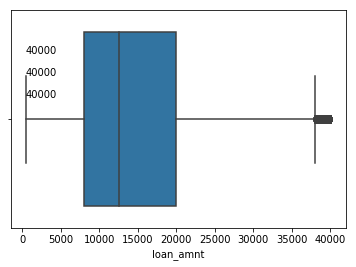

funded_amnt


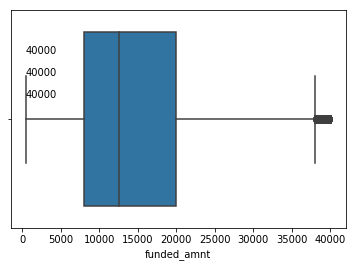

installment


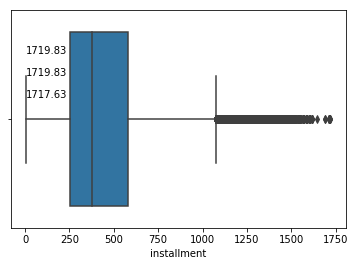

annual_inc


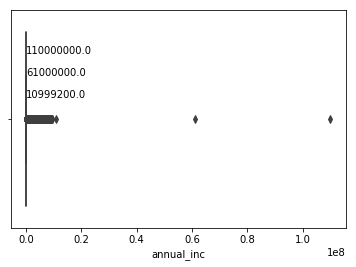

dti


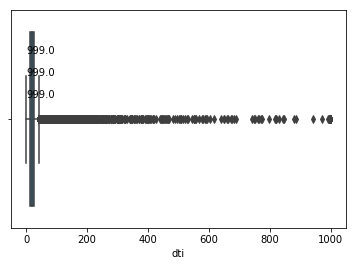

delinq_2yrs


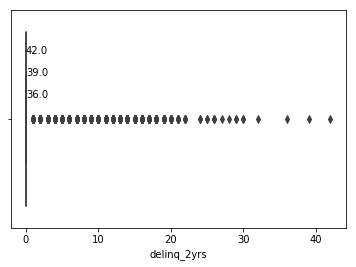

open_acc


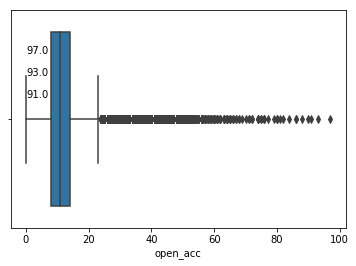

pub_rec


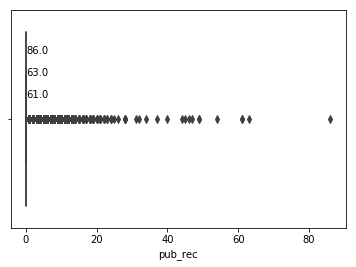

fico_range_high


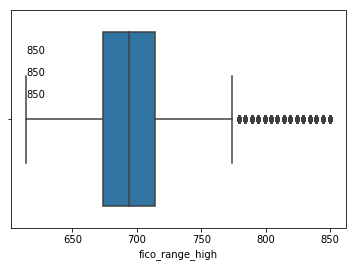

fico_range_low


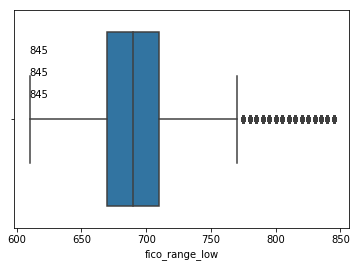

revol_bal


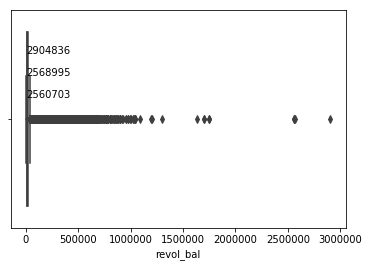

total_pymnt


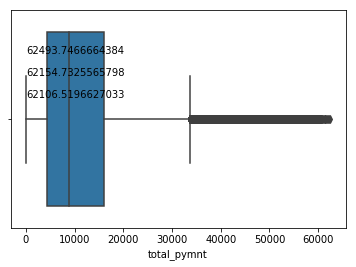

recoveries


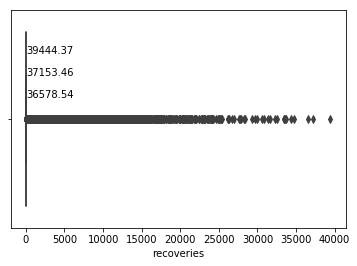

int_rate


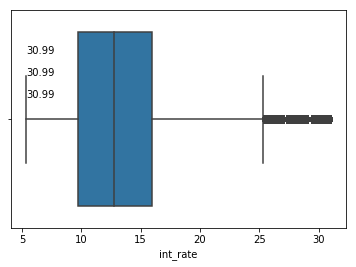

revol_util


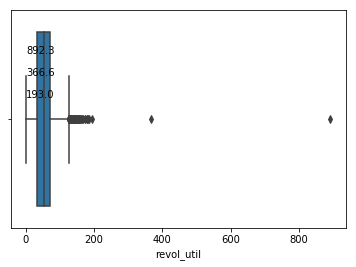

ret_PESS


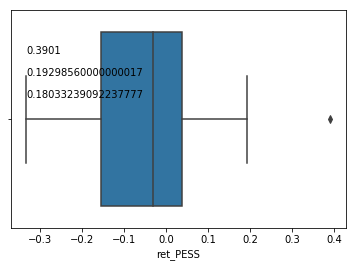

ret_OPT


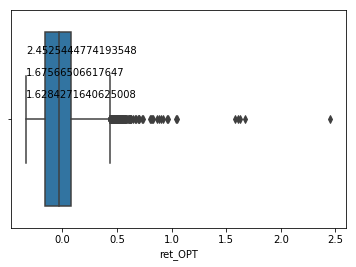

ret_INTa


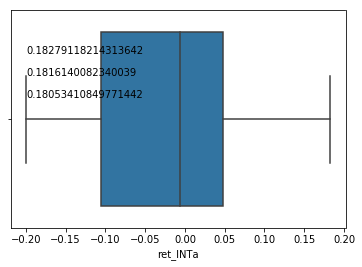

ret_INTb


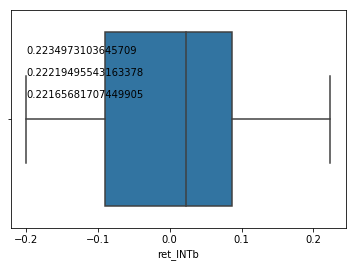

Field name:  term
Number of distict values:  2
term
 36 months    1260610
 60 months     498598
dtype: int64


Field name:  grade
Number of distict values:  7
grade
A    296996
B    520527
C    521315
D    254390
E    116174
F     38424
G     11382
dtype: int64


Field name:  emp_length
Number of distict values:  12
emp_length
1 year       114808
10+ years    585453
2 years      158386
3 years      139611
4 years      105001
5 years      108455
6 years       80425
7 years       74482
8 years       75648
9 years       66527
< 1 year     145876
dtype: int64


Field name:  home_ownership
Number of distict values:  6
home_ownership
ANY            504
MORTGAGE    869367
OTHER          182
OWN         191886
RENT        697215
dtype: int64


Field name:  verification_status
Number of distict values:  3
verification_status
Not Verified       561817
Source Verified    668294
Verified           529097
dtype: int64


Field name:  loan_status
Number of distict values:  9
loan_status
Charged Off  

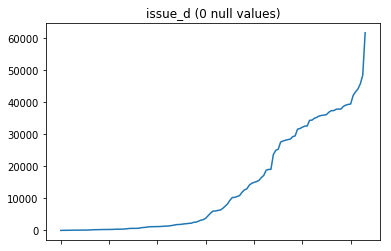

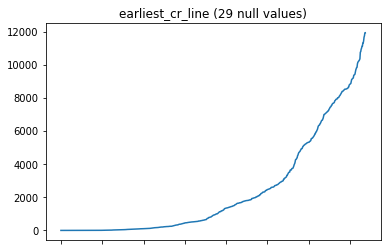

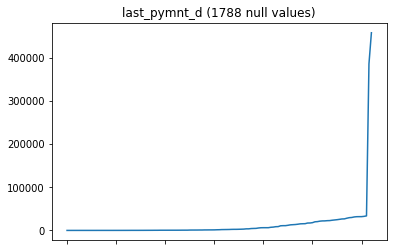

In [24]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [25]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious

df_list = ['annual_inc','dti','delinq_2yrs','open_acc','pub_rec','revol_bal',
           'recoveries','revol_util','ret_OPT']
final=final_data
nrows=len(final_data)

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")
final.dropna(subset=required_cols,inplace=True)

for col in df_list:
    p = np.percentile(final[col],99)
    final_data=final_data[final_data[col] <= p]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 153506 rows


In [26]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data["loan_status"] != "Current"]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 732019 rows


In [27]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data["issue_d"] >= datetime.date(2010, 1, 1)]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 7758 rows


### Drop null values - Rows have been removed while handling outliers

In [28]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data.dropna(subset=required_cols,inplace=True) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


### Visualize clean data

loan_amnt


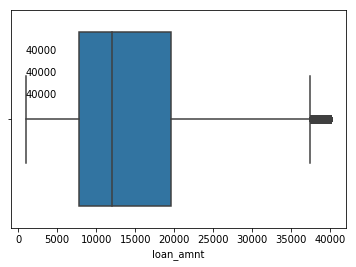

funded_amnt


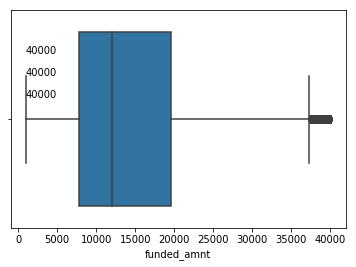

installment


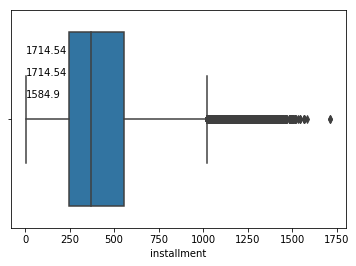

annual_inc


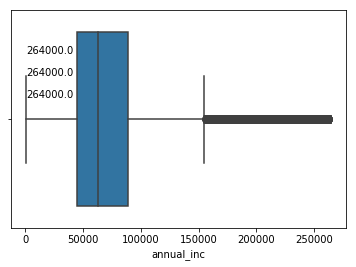

dti


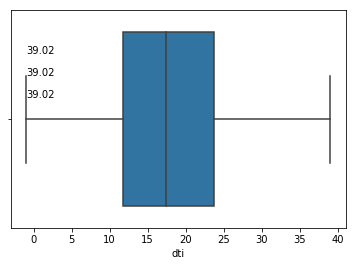

delinq_2yrs


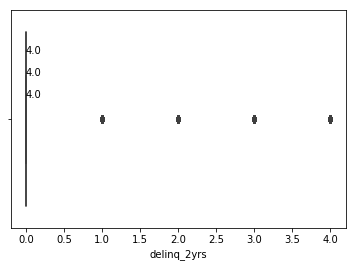

open_acc


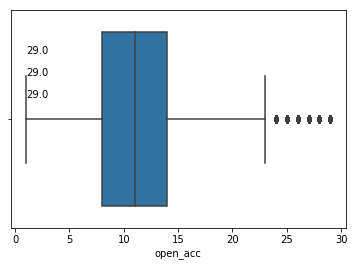

pub_rec


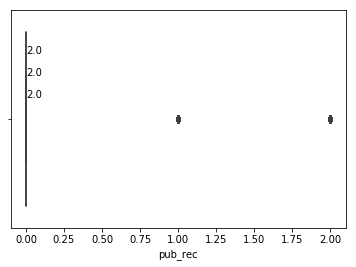

fico_range_high


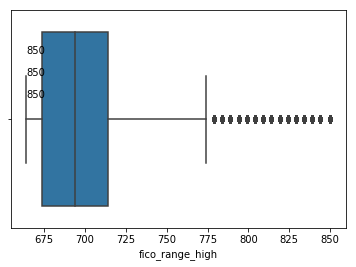

fico_range_low


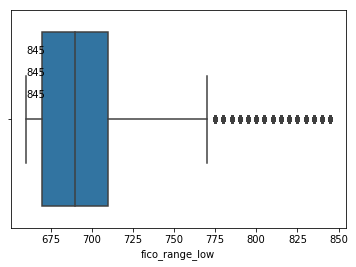

revol_bal


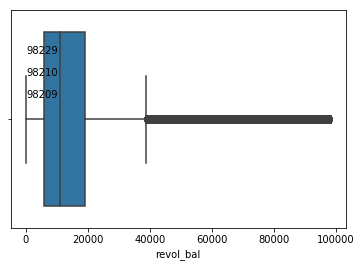

total_pymnt


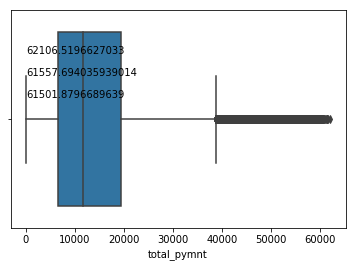

recoveries


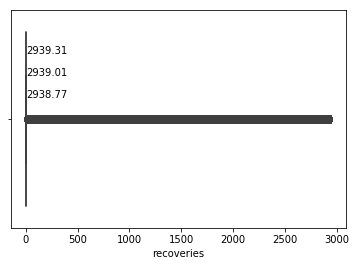

int_rate


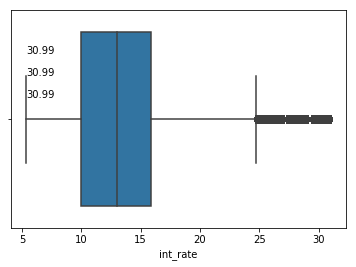

revol_util


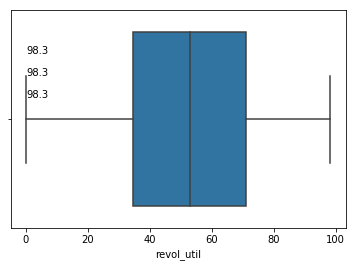

ret_PESS


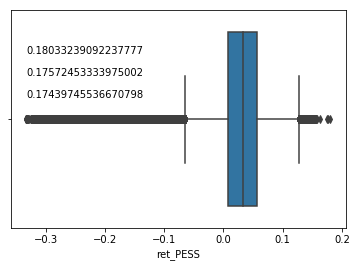

ret_OPT


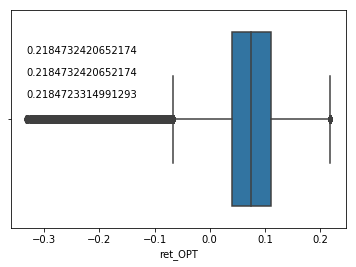

ret_INTa


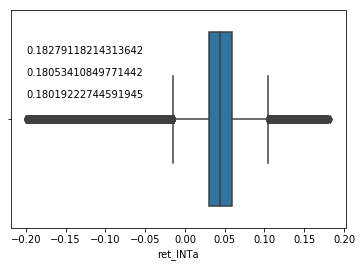

ret_INTb


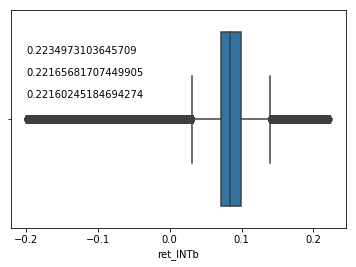

Field name:  term
Number of distict values:  2
term
 36 months    671237
 60 months    200906
dtype: int64


Field name:  grade
Number of distict values:  7
grade
A    148156
B    258930
C    250052
D    134118
E     59796
F     17203
G      3888
dtype: int64


Field name:  emp_length
Number of distict values:  12
emp_length
1 year        57396
10+ years    281658
2 years       79340
3 years       70031
4 years       52414
5 years       55660
6 years       42561
7 years       41151
8 years       41163
9 years       33929
< 1 year      69245
dtype: int64


Field name:  home_ownership
Number of distict values:  6
home_ownership
ANY            124
MORTGAGE    428459
OTHER           49
OWN          88986
RENT        354484
dtype: int64


Field name:  verification_status
Number of distict values:  3
verification_status
Not Verified       276052
Source Verified    320361
Verified           275730
dtype: int64


Field name:  loan_status
Number of distict values:  8
loan_status
Charged Off    

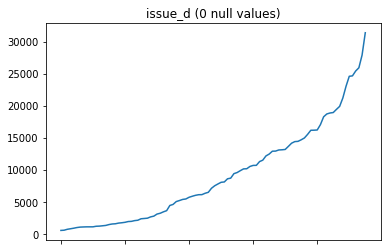

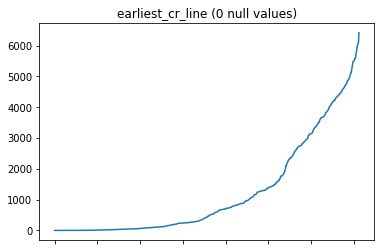

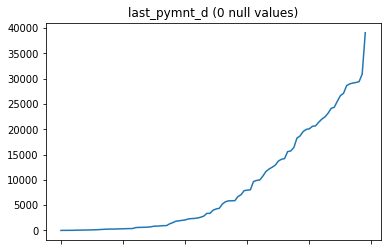

In [29]:
# Visualize the data again after cleaning
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

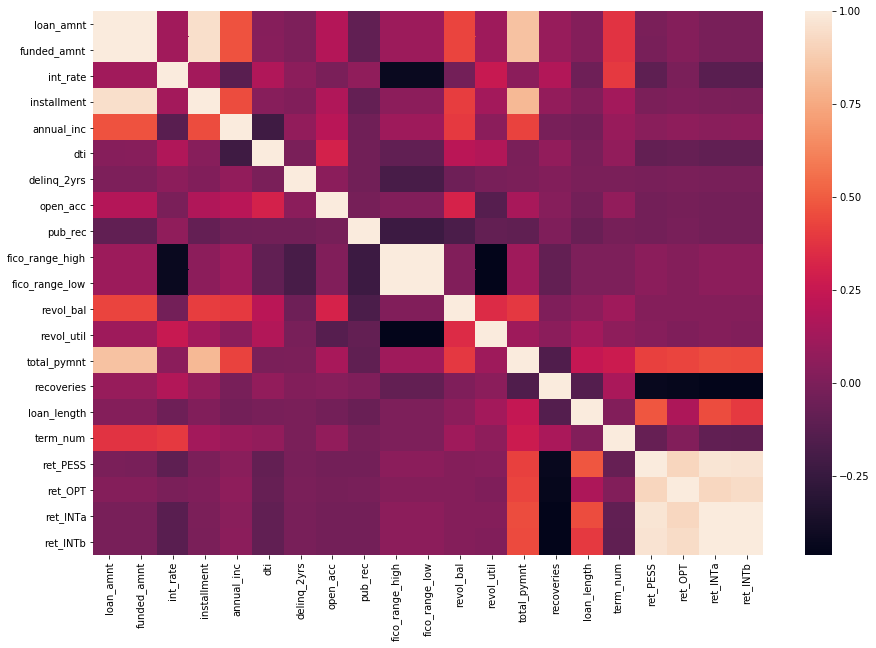

In [30]:
# Visualize the feature correlations
# use sns scatter or pairplot

corr1 = final_data.corr()
fig1, ax1 = plt.subplots(figsize=(15, 10))
seaborn.heatmap(corr1, ax=ax1)

In [31]:
cols= list(final_data.columns)
cols=sorted(list(set(cols) - set(date_cols) - set(cat_cols) - set(['id'])))
print(len(cols))

21


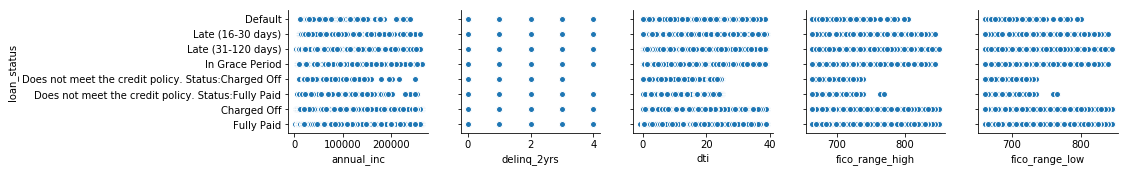

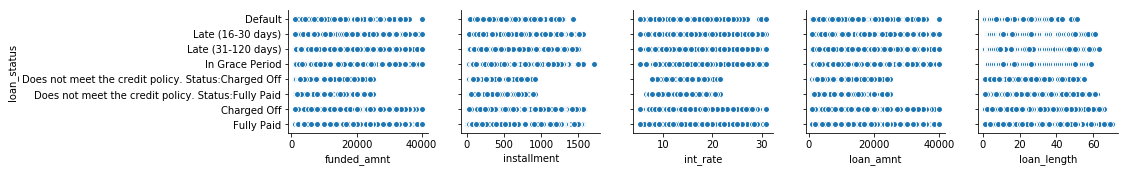

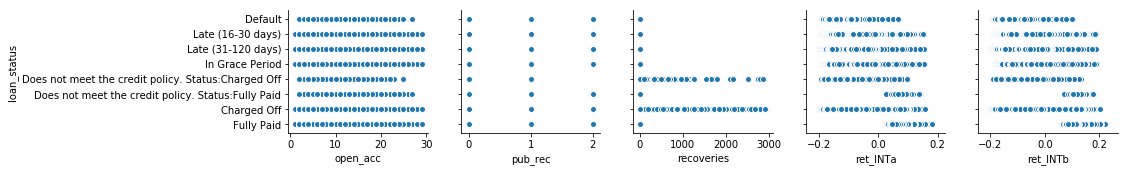

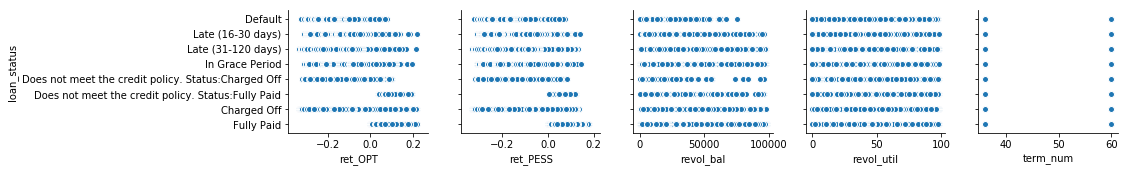

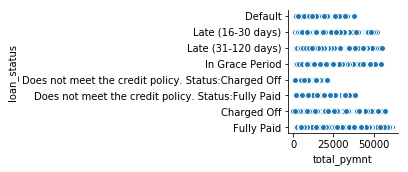

In [32]:
l=len(cols)
a=0
for i in range(len(cols)):
    if i==a:
        if l-i>=5:
            seaborn.pairplot(data=final_data, x_vars=cols[i:i+5], y_vars='loan_status')
            a+=5
        else:
            seaborn.pairplot(data=final_data, x_vars=cols[i:l], y_vars='loan_status')

**Question:** What do you observe after removing the outliers?

**Answer:** <b> After removing the outliers and observing the pairplots above, the points seems to be uniformly distributed over a specific range and no distinct outliers can be seen </b>

### Data Exploration
Solution to Q.7 from the handout

In [33]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : x.ret_OPT.mean()*100) # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : x.ret_PESS.mean()*100) # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : x.ret_INTa.mean()*100) # average return for M3
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : x.ret_INTb.mean()*100) # average return for M3
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : x.int_rate.mean()) # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,16.987581,7.192419,7.215644,3.712850,1.520570,3.047256,6.656962
B,29.688939,15.233075,10.847920,4.635059,1.283883,2.907623,6.506827
C,28.670986,24.958809,14.077595,4.789117,0.220485,2.165896,5.678815
D,15.377983,32.686142,17.550941,5.003572,-0.208780,1.782471,5.212794
E,6.856215,42.840658,20.569133,4.211496,-1.176331,0.885680,4.126473
F,1.972498,58.181712,24.276351,0.842919,-2.789677,-0.890674,1.962834
G,0.445798,75.462963,27.156127,-4.879140,-6.940201,-4.826056,-2.546675


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [34]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = list(set(continuous_features)- set(['total_pymnt', 'recoveries']))

**Question:** Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

**Answer:** 

In [35]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )